# Gráficas de Resultados
Este cuaderno carga resultados de `resultados/*/*.json` y el CSV `Tiempos para las instancias.csv` para generar gráficas comparativas de distancia y tiempo para ACO, Genético y, cuando exista, GAMS.

In [87]:
from pathlib import Path
import json
import math
import sys, subprocess

def ensure_packages(pkgs):
    missing = []
    loaded = {}
    for pkg in pkgs:
        try:
            loaded[pkg] = __import__(pkg)
        except Exception:
            missing.append(pkg)
    if missing:
        print('Instalando paquetes faltantes con pip:', ', '.join(missing))
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', *missing])
        except Exception as e:
            print('No se pudieron instalar automáticamente:', missing, e)
            print('Instálalos manualmente con: pip install', ' '.join(missing))
    # Reimportar los que faltaban
    import importlib
    for pkg in missing:
        try:
            loaded[pkg] = importlib.import_module(pkg)
        except Exception:
            pass
    # Devolver módulos cargados y lista final de faltantes
    still_missing = [p for p in pkgs if p not in loaded]
    return loaded, still_missing

mods, still_missing = ensure_packages(['pandas','matplotlib','seaborn'])
import importlib as _importlib
pd = mods.get('pandas') or _importlib.import_module('pandas')
# Importar explícitamente pyplot para evitar colisiones con matplotlib.figure
try:
    plt = _importlib.import_module('matplotlib.pyplot')
except Exception:
    import matplotlib as _mpl
    plt = _mpl
try:
    sns = mods.get('seaborn') or _importlib.import_module('seaborn')
except Exception:
    sns = None
if sns is None:
    print('Aviso: seaborn no disponible. Usaré matplotlib; las gráficas serán más simples.')
    try:
        import matplotlib as _mpl
        _mpl.style.use('ggplot')
    except Exception:
        pass
else:
    sns.set(style='whitegrid')
BASE = Path('.')
DIR_RES = BASE / 'resultados'
CSV_TIEMPOS = BASE / 'Tiempos para las instancias.csv'
DIR_OUT = BASE / 'graficas'
DIR_OUT.mkdir(exist_ok=True)


In [88]:
def parse_instancia_name(name:str):
    try:
        a,b = name.split('_')
        return int(a), int(b)
    except Exception:
        return None, None

def load_json_results(dir_res:Path=DIR_RES):
    rows = []
    for json_path in sorted(dir_res.glob('*/*.json')):
        instancia = json_path.stem  # '10_100'
        grupos, n = parse_instancia_name(instancia)
        try:
            data = json.loads(json_path.read_text(encoding='utf-8'))
        except Exception as e:
            print(f"No se pudo leer {json_path}: {e}")
            continue
        for alg in ('genetico','aco'):
            if alg in data:
                d = data[alg]
                distancia = d.get('distancia', None)
                tiempo = d.get('tiempo', None)
                rows.append({
                    'instancia': instancia,
                    'grupos': grupos,
                    'n': n,
                    'algoritmo': alg,
                    'distancia': distancia,
                    'tiempo': tiempo,
                })
    df = pd.DataFrame(rows)
    # Orden consistente
    if not df.empty:
        df = df.sort_values(['n','grupos','algoritmo']).reset_index(drop=True)
    return df

df_res = load_json_results()
print(f"Instancias en JSON: {df_res['instancia'].nunique() if not df_res.empty else 0}")
df_res.head()


Instancias en JSON: 40


,instancia,grupos,n,algoritmo,distancia,tiempo
0,1_40,1,40,aco,112.345831,33.769169
1,1_40,1,40,genetico,143.789111,1.299857
2,2_40,2,40,aco,153.719654,31.671080
3,2_40,2,40,genetico,169.981956,1.189792
4,3_40,3,40,aco,142.938675,31.408782


In [89]:
def load_csv_tiempos(path:Path=CSV_TIEMPOS):
    if not path.exists():
        return pd.DataFrame()
    df = pd.read_csv(path)
    # Normalizar encabezados
    cols = {c:c.strip() for c in df.columns}
    df = df.rename(columns=cols)
    rename = {
        'Instancia': 'instancia',
        'Instancia ': 'instancia',
        'Tiempo en gams': 'tiempo_gams',
        'Valor optimo en gams': 'valor_gams',
        'Valor optimo en gams ': 'valor_gams',
        'Tiempo Algoritmo genetico': 'tiempo_genetico',
        'Valor  Genetico': 'valor_genetico',
        'Tiempo ACO': 'tiempo_aco',
        'Valor ACO': 'valor_aco',
    }
    for k,v in rename.items():
        if k in df.columns:
            df = df.rename(columns={k:v})
    # Quitar posibles espacios en instancia
    if 'instancia' in df.columns:
        df['instancia'] = df['instancia'].astype(str).str.strip()
        df[['grupos','n']] = df['instancia'].str.split('_', n=1, expand=True)
        with pd.option_context('mode.use_inf_as_na', True):
            df['grupos'] = pd.to_numeric(df['grupos'], errors='coerce').astype('Int64')
            df['n'] = pd.to_numeric(df['n'], errors='coerce').astype('Int64')
    return df

df_csv = load_csv_tiempos()
print(f"Filas en CSV: {len(df_csv)}")
missing_match = set(df_csv['instancia']) - set(df_res['instancia']) if not df_csv.empty and not df_res.empty else set()
if missing_match:
    print('Advertencia: instancias en CSV sin JSON correspondiente:', sorted(list(missing_match))[:10], '...')
df_csv.head()


Filas en CSV: 40
Advertencia: instancias en CSV sin JSON correspondiente: ['6_160'] ...


,instancia,tiempo_gams,valor_gams,tiempo_genetico,valor_genetico,tiempo_aco,valor_aco,grupos,n
0,1_40,19.839,110.4,2.413607,130.694720,65.270749,112.362968,1,40
1,2_40,24.495,146.7,2.560993,158.059277,64.296391,152.744744,2,40
2,3_40,1.977,142.0,2.320510,161.209752,63.355181,143.815686,3,40
3,4_40,21.347,111.9,2.335597,141.483601,69.353550,112.670847,4,40
4,5_40,3.423,150.0,2.452739,178.779827,67.306587,156.387427,5,40


In [90]:
# Preparar DataFrames para gráficas usando únicamente el CSV
if df_csv.empty:
    raise RuntimeError('No se encontró o está vacío el CSV de tiempos: Tiempos para las instancias.csv')
# Construir formato largo con columnas compatibles: instancia, grupos, n, algoritmo, distancia, tiempo
partes = []
for alg in ('genetico','aco'):
    tcol = f'tiempo_{alg}'
    vcol = f'valor_{alg}'
    cols = ['instancia','grupos','n', tcol, vcol]
    faltan = [c for c in cols if c not in df_csv.columns]
    if faltan:
        raise RuntimeError(f'Faltan columnas en CSV para {alg}: {faltan}')
    sub = df_csv[cols].rename(columns={tcol:'tiempo', vcol:'distancia'}).copy()
    sub['algoritmo'] = alg
    partes.append(sub)
df_long = pd.concat(partes, ignore_index=True)
# Añadir columnas de GAMS si existen en CSV
if {'valor_gams','tiempo_gams'}.issubset(df_csv.columns):
    gams = df_csv[['instancia','grupos','n','valor_gams','tiempo_gams']].drop_duplicates(['instancia','grupos','n'])
    df_long = df_long.merge(gams, on=['instancia','grupos','n'], how='left')

df_long.head()


,instancia,grupos,n,algoritmo,distancia,tiempo,valor_gams,tiempo_gams
0,1_40,1,40,aco,112.345831,33.769169,110.4,19.839
1,1_40,1,40,genetico,143.789111,1.299857,110.4,19.839
2,2_40,2,40,aco,153.719654,31.671080,146.7,24.495
3,2_40,2,40,genetico,169.981956,1.189792,146.7,24.495
4,3_40,3,40,aco,142.938675,31.408782,142.0,1.977


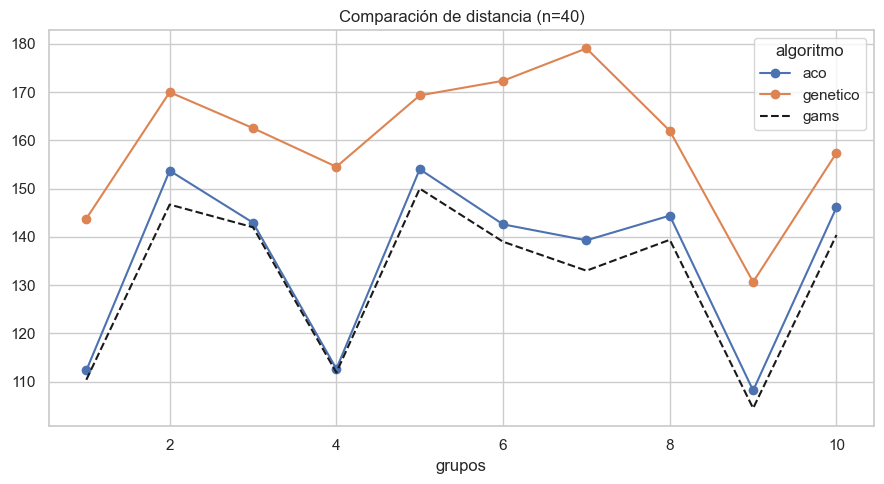

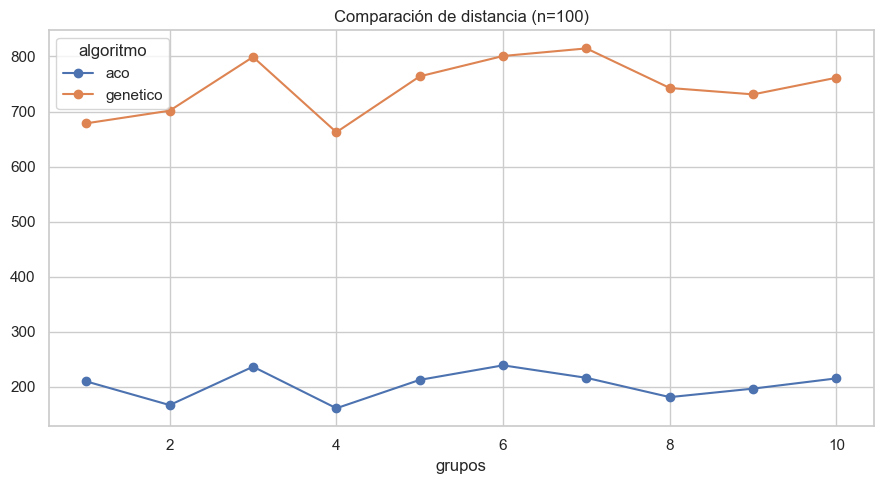

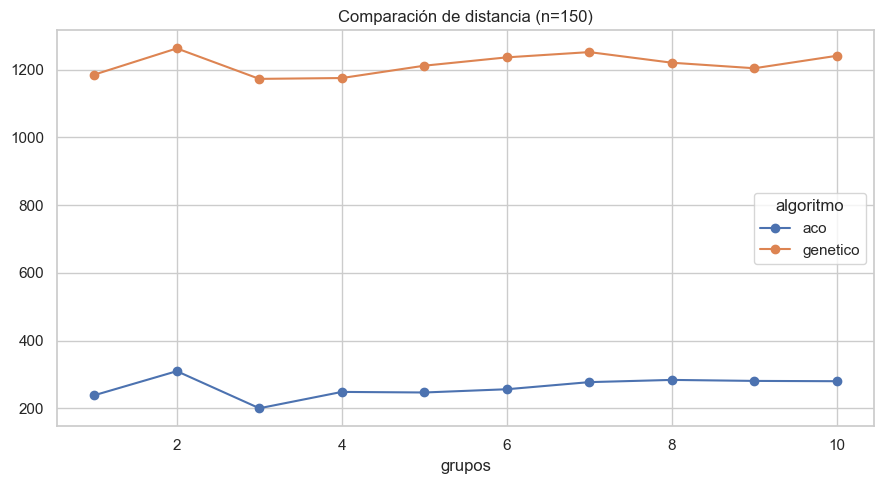

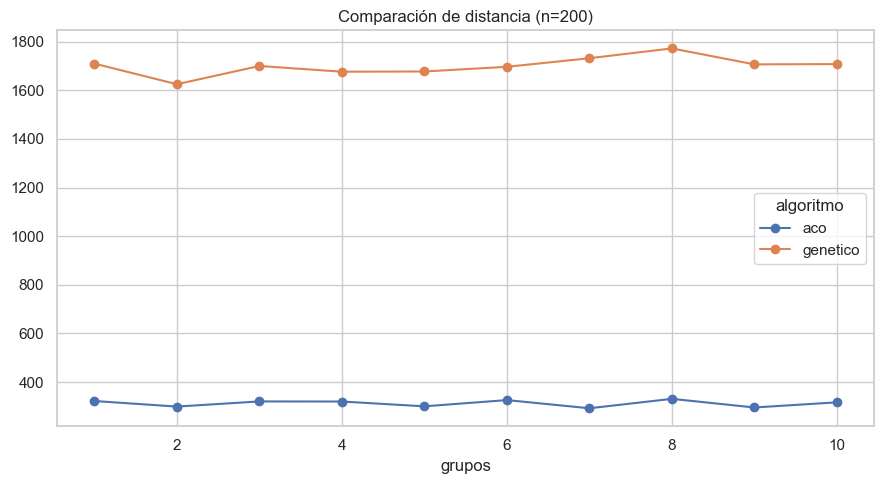

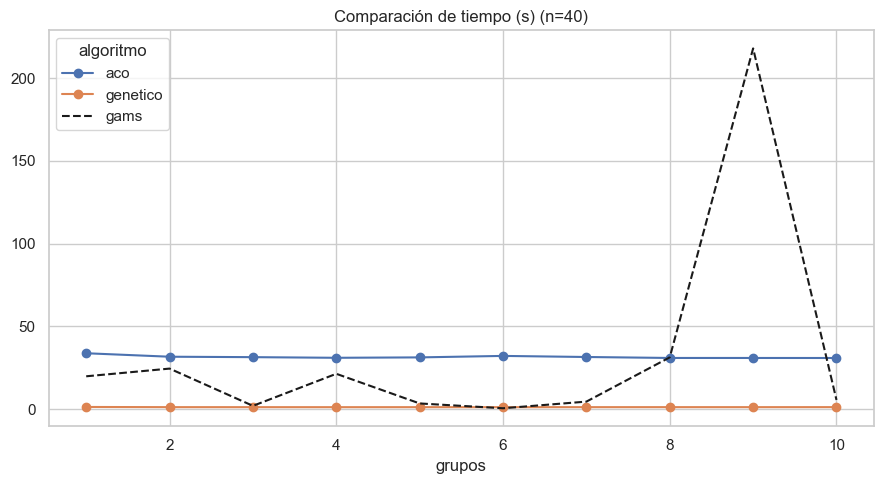

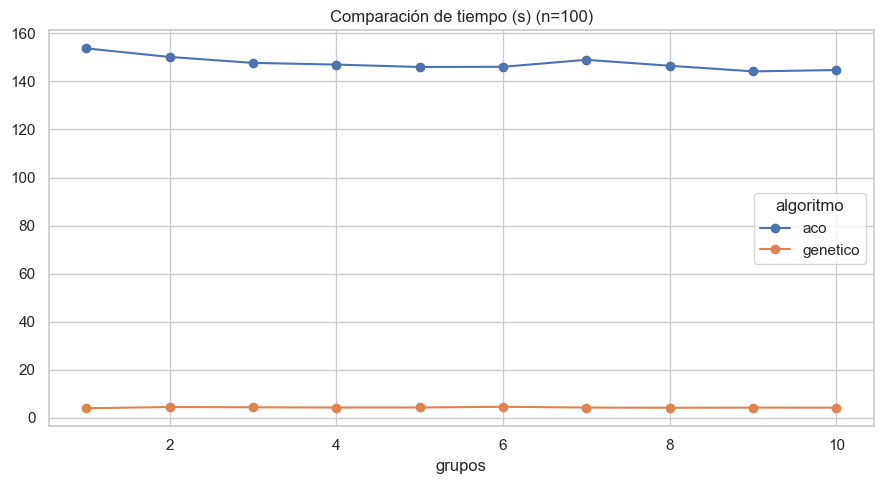

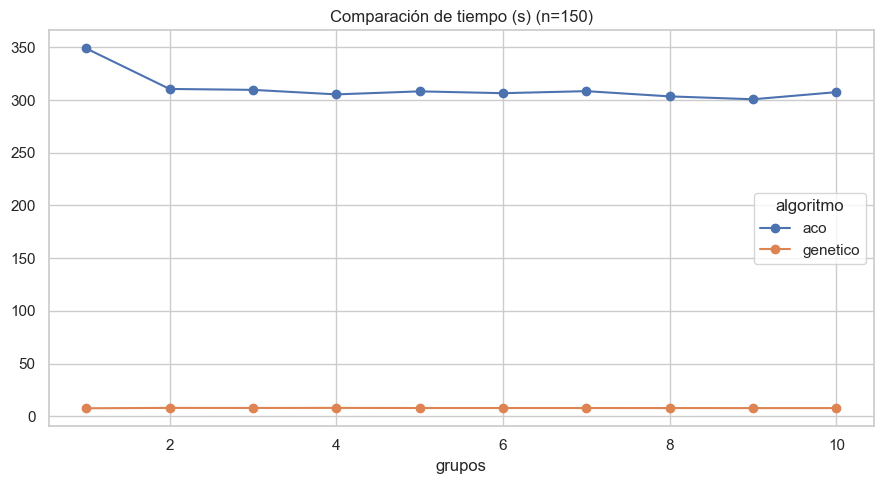

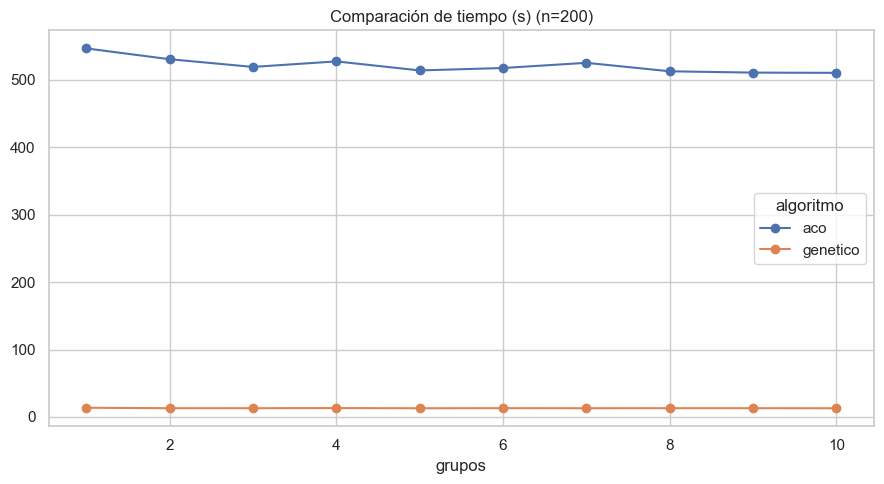

In [91]:
def plot_metric(df, metric:str, title:str, fname_prefix:str):
    # Facet por n (tamaño de instancia)
    # Asegurar tipos numéricos básicos
    dft = df.copy()
    dft['grupos'] = pd.to_numeric(dft['grupos'], errors='coerce')
    if metric in dft.columns:
        dft[metric] = pd.to_numeric(dft[metric], errors='coerce')
    ns = sorted(pd.Series(dft['n']).dropna().unique())
    if not ns:
        ns = [None]
    for nval in ns:
        dff = dft if nval is None else dft[dft['n'] == nval]
        if dff.empty:
            continue
        plt.figure(figsize=(9,5))
        # Trazado robusto: pivot para asegurar alineación por grupos
        wide = dff.pivot_table(index='grupos', columns='algoritmo', values=metric, aggfunc='first').sort_index()
        if sns is not None:
            for alg in wide.columns:
                plt.plot(wide.index, wide[alg], marker='o', label=str(alg))
            plt.legend(title='algoritmo')
        else:
            for alg in wide.columns:
                plt.plot(wide.index, wide[alg], marker='o', label=str(alg))
            plt.legend(title='algoritmo')
        # Agregar línea GAMS si existe
        if f'valor_gams' in dff.columns and metric == 'distancia':
            # Hay un valor por instancia; graficamos como puntos/linea negra
            gplot = dff.drop_duplicates(['instancia'])
            if not gplot['valor_gams'].isna().all():
                gplot = gplot.sort_values('grupos')
                plt.plot(gplot['grupos'], gplot['valor_gams'], 'k--', label='gams')
        if f'tiempo_gams' in dff.columns and metric == 'tiempo':
            gplot = dff.drop_duplicates(['instancia'])
            if not gplot['tiempo_gams'].isna().all():
                gplot = gplot.sort_values('grupos')
                plt.plot(gplot['grupos'], gplot['tiempo_gams'], 'k--', label='gams')
        plt.legend(title='algoritmo')
        ttl = title + (f' (n={nval})' if nval is not None else '')
        plt.title(ttl)
        plt.xlabel('grupos')
        plt.tight_layout()
        out = DIR_OUT / f"{fname_prefix}_n{nval if nval is not None else 'NA'}.png"
        plt.savefig(out, dpi=160)
        plt.show()

plot_metric(df_long, 'distancia', 'Comparación de distancia', 'distancia')
plot_metric(df_long, 'tiempo', 'Comparación de tiempo (s)', 'tiempo')


In [92]:
# Resumen comparativo
pivot = (df_long.pivot_table(index=['instancia','grupos','n'], columns='algoritmo', values=['distancia','tiempo']))
pivot.columns = [f"{a}_{b}" for a,b in pivot.columns]
pivot = pivot.reset_index()
if {'distancia_aco','distancia_genetico'}.issubset(pivot.columns):
    pivot['distancia_aco_mejor'] = pivot['distancia_aco'] < pivot['distancia_genetico']
    print('ACO mejor distancia en', int(pivot['distancia_aco_mejor'].sum()), 'de', len(pivot), 'instancias')
if {'tiempo_aco','tiempo_genetico'}.issubset(pivot.columns):
    pivot['aco_mas_lento'] = pivot['tiempo_aco'] > pivot['tiempo_genetico']
    print('ACO más lento que Genético en', int(pivot['aco_mas_lento'].sum()), 'de', len(pivot), 'instancias')
pivot.head()


ACO mejor distancia en 40 de 40 instancias
ACO más lento que Genético en 40 de 40 instancias


,instancia,grupos,n,distancia_aco,distancia_genetico,tiempo_aco,tiempo_genetico,distancia_aco_mejor,aco_mas_lento
0,10_100,10,100,215.345145,761.489746,144.763745,4.147204,True,True
1,10_150,10,150,280.384424,1240.976187,307.510575,7.865000,True,True
2,10_200,10,200,316.479352,1707.626868,510.356601,12.916072,True,True
3,10_40,10,40,146.116337,157.403544,30.898948,1.199594,True,True
4,1_100,1,100,209.809871,678.615050,153.772170,3.899168,True,True
